In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import date
import codebase

- below Hoover Dam: 4152103
- Lee's Ferry: 4152450
- US-Mexico border: 4152050
- upstream of Lake Powell (San Juan River trib): 4152600

In [2]:
## define experimental set-up

# grdc stored as floats in the downlaod jsons
grdc_id = 4152103
grdc_sub_ids = [4152450,4152600] ## MUST BE ORDERED DOWNSTREAM (first) TO UPSTREAM (last)
dam_name = 'glen canyon'
start_year = 2018
stop_year_ex = 2024

In [3]:
## Other variables and filepaths
grdc_dir = "/global/scratch/users/ann_scheliga/aux_dam_datasets/GRDC_CRB/"
met_dir = "/global/scratch/users/ann_scheliga/era5_data/"
res_dir = "/global/scratch/users/ann_scheliga/CYGNSS_daily/"

In [4]:
# For debugging
def check_data_format(df):
    print(df.head(2))
    print(df.tail(2))
    print('structure type:',type(df))
    print('index type:',type(df.index))
    print('first index:',df.index[0])
    print('Inferred frequency:',df.index.inferred_freq)


In [6]:
# Create output dataframe
full_time = pd.date_range(start=date(start_year,1,1), end=date(stop_year_ex,1,1),freq='D')
output_df = pd.DataFrame(index = full_time)

In [7]:
## import sw_area
sw_area = codebase.load_data.load_daily_reservoir_CYGNSS_area(
    dam_name, filepath=res_dir
)

output_df['SW_area'] = sw_area
check_data_format(sw_area)

2019-01-01    380.752060
2019-01-02    362.621009
Name: Area km2, dtype: float64
2023-12-31    298.685200
2024-01-01    293.913871
Name: Area km2, dtype: float64
structure type: <class 'pandas.core.series.Series'>
index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
first index: 2019-01-01 00:00:00
Inferred frequency: D


In [8]:
## Calculate SW_flag
output_df['SW_flag'] = 0
# where SW_area has a value, SW_flag is true
output_df.loc[~output_df['SW_area'].isna(),'SW_flag'] = 1 

check_data_format(output_df['SW_flag'])

2018-01-01    0
2018-01-02    0
Freq: D, Name: SW_flag, dtype: int64
2023-12-31    1
2024-01-01    1
Freq: D, Name: SW_flag, dtype: int64
structure type: <class 'pandas.core.series.Series'>
index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
first index: 2018-01-01 00:00:00
Inferred frequency: D


In [9]:
## import GRDC
watershed_gpd, grdc_Q = codebase.load_data.load_GRDC_station_data_by_ID(
    grdc_id,
    filepath=grdc_dir,
    timeseries_dict={"start_year": start_year, "stop_year": stop_year_ex},
)

output_df['Q'] = grdc_Q
check_data_format(grdc_Q)

ERROR 1: PROJ: proj_create_from_database: Open of /global/home/users/ann_scheliga/.conda/envs/rioxarray_env/share/proj failed


              Q m3s
Date               
2018-01-01  288.831
2018-01-02  286.000
              Q m3s
Date               
2021-09-11  255.418
2021-09-12  227.950
structure type: <class 'pandas.core.frame.DataFrame'>
index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
first index: 2018-01-01 00:00:00
Inferred frequency: D


In [10]:
# Given that sub-basins exist
subbasins_GRDC = list(map(
    lambda id: codebase.load_data.load_GRDC_station_data_by_ID(
        id,filepath=grdc_dir,
        timeseries_dict={"start_year": start_year, "stop_year": stop_year_ex}
        ),
    grdc_sub_ids))
# subbasin_zipped = dict(zip(grdc_sub_ids,subbasins_GRDC))

# drop flow timeseries tuple from list, leave just the geoDataFrame(s)
subbasin_shps = [output[0] for output in subbasins_GRDC]
def create_XOR_subasins(list_of_shps,base_gpd):
    processed_shps = base_gpd.iloc[:,-1]
    processed_shps.index = ['_ex0']
    processed_shps.index.rename('relative_order',inplace=True)

    for idx, shp in enumerate(list_of_shps):
        shp_to_diff = shp.iloc[0,-1]
        processed_shps = processed_shps.difference(shp_to_diff)
        processed_shps.loc['_ex'+str(idx+1)] = shp_to_diff
    return processed_shps

In [11]:
XOR_gpd = create_XOR_subasins(subbasin_shps,watershed_gpd)

<Axes: >

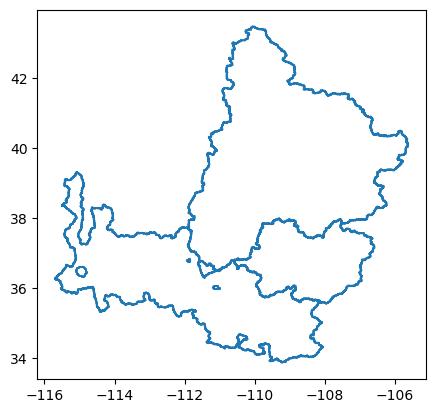

In [14]:
XOR_gpd.boundary.plot()

In [ ]:
## Can't get mode function to work easily.
# Tried scipy and statistics modules
# type_precip_test = codebase.area_subsets.era5_shape_subset_and_concat_from_file_pattern(
#     filepath = met_dir,
#     input_pattern = r'daily_precip_type',
#     subset_gpd = watershed_gpd,
#     concat_dict = concat_dict,
#     agg_function = mode
# )

In [ ]:
def add_era5_met_data_by_shp(input_gpd,col_suffix = "",start_year=-1,stop_year_ex=-1):
    """
    Load areal aggregated temp and precip based on provided gpd.

    Long Description
    ----------------
    Uses `area_subsets.era5_shape_subset_and_concat_from_file_pattern` for each variable.
    Searches for all instances of a substring (ex: 'daily_tempK'),
    and concatenates all found files according to hard-coded concat_dict dimensions.
    For precipitation, aggregates using np.nansum
    For temperature, aggregates using np.nanmean.
    start and stop year not used, but included in case useful in future edits.

    Inputs
    ------
    input_gpd : geopandas.GeoDataFrame
        geometry to subset data
    col_suffix : str
        default = "" (empty)
        added to column names in final output dataframe
        useful when using this function multiple times
    start_year, stop_year_ex : int
        default = -1
        not used, passed in case future edits need the bounds
        for pattern parsing or filtering.
    """
    
    concat_dict = {"dim": "valid_time"}

    __ , tempK_1dim = codebase.area_subsets.era5_shape_subset_and_concat_from_file_pattern(
        filepath = met_dir,
        input_pattern = r'daily_tempK',
        subset_gpd = input_gpd,
        concat_dict = concat_dict,
        agg_function = np.nanmean
    )
    tempK_1dim.rename('tempK',inplace=True)

    __ , precip_1dim = codebase.area_subsets.era5_shape_subset_and_concat_from_file_pattern(
        filepath = met_dir,
        input_pattern = r'daily_tot_precip',
        subset_gpd = input_gpd,
        concat_dict = concat_dict,
        agg_function = np.nansum
    )
    precip_1dim.rename('precipm',inplace=True)
    met_df = pd.concat([tempK_1dim, precip_1dim],axis=1).add_suffix(col_suffix)
    return met_df

In [17]:
sub_extension = '_tot0'
met_df = add_era5_met_data_by_shp(watershed_gpd,col_suffix=sub_extension)
output_df = output_df.join(met_df, how='left')

Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Projected to equal area
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Projected to equal area


In [18]:
output_df

,SW_area,SW_flag,Q,tempK_tot0,precipm_tot0
2018-01-01,NaN,0,288.831,NaN,1.053810e-04
2018-01-02,NaN,0,286.000,NaN,4.053116e-05
2018-01-03,NaN,0,322.812,NaN,9.536743e-07
2018-01-04,NaN,0,274.956,NaN,1.721382e-04
2018-01-05,NaN,0,247.206,NaN,0.000000e+00
...,...,...,...,...,...
2023-12-28,311.090655,1,NaN,NaN,2.083778e-04
2023-12-29,293.913871,1,NaN,NaN,4.768372e-06
2023-12-30,298.685200,1,NaN,NaN,1.450539e-03
2023-12-31,298.685200,1,NaN,NaN,1.636505e-03
